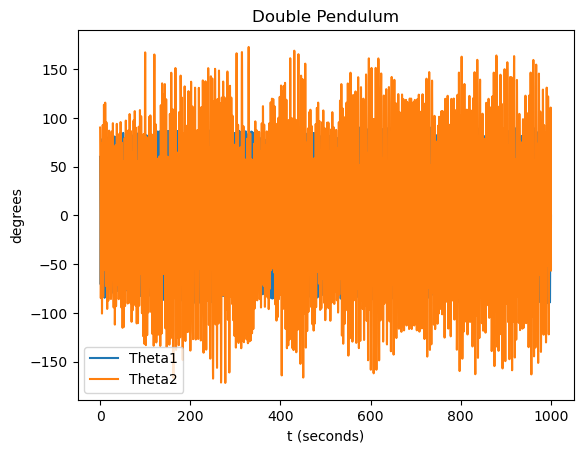

Epoch [1/150], Train Loss: 0.017669, Val Loss: 0.000687
Epoch [2/150], Train Loss: 0.000193, Val Loss: 0.000005
Epoch [3/150], Train Loss: 0.000003, Val Loss: 0.000002
Epoch [4/150], Train Loss: 0.000001, Val Loss: 0.000001
Epoch [5/150], Train Loss: 0.000001, Val Loss: 0.000001
Epoch [6/150], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [7/150], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [8/150], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [9/150], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [10/150], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [11/150], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [12/150], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [13/150], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [14/150], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [15/150], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [16/150], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [17/150], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [18/150], Train Loss: 0.000000, Va

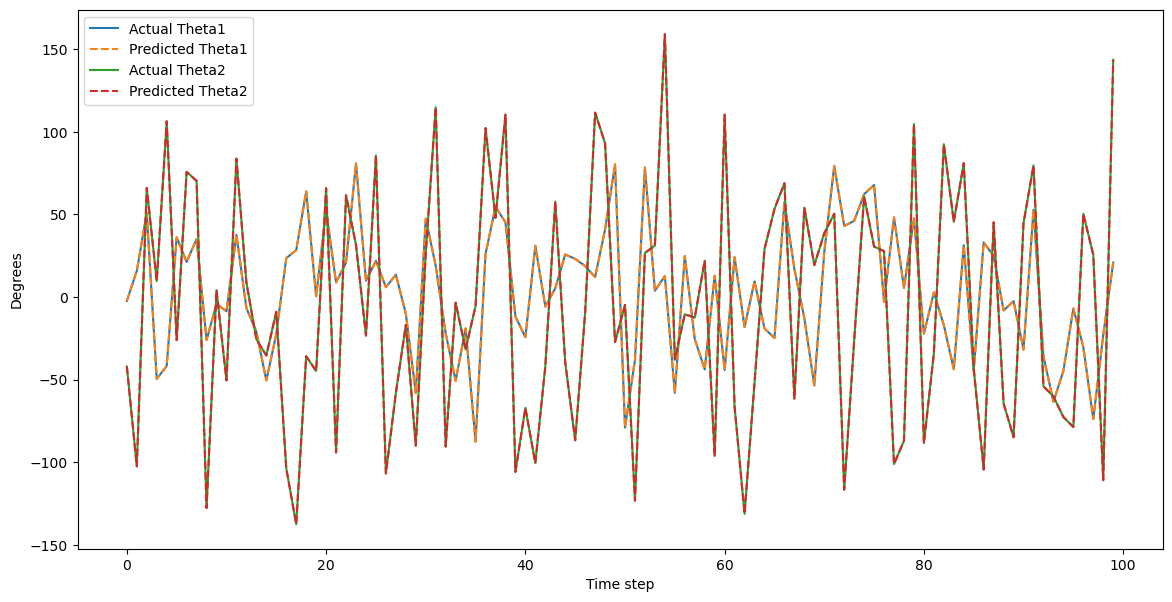

In [1]:
# Original model by Vasista Ramachandruni
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from torch.utils.data import TensorDataset, DataLoader
# Preprocessing
g = 9.81
L1 = 1
L2 = 1
m1 = 1.0
m2 = 1.0
def f(r, t, L1, L2):
    theta1 = r[0]
    omega1 = r[1]
    theta2 = r[2]
    omega2 = r[3]
    ftheta1 = omega1
    fomega1 = (-g * (2 * m1 + m2) * sin(theta1) - m2 * g * sin(theta1 - 2 * theta2)
               - 2 * sin(theta1 - theta2) * m2 * (omega2**2 * L2 + omega1**2 * L1 * cos(theta1 - theta2))) / \
              (L1 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))
    ftheta2 = omega2
    fomega2 = (2 * sin(theta1 - theta2) * (omega1**2 * L1 * (m1 + m2) + g * (m1 + m2) * cos(theta1)
                                           + omega2**2 * L2 * m2 * cos(theta1 - theta2))) / \
              (L2 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))
    return np.array([ftheta1, fomega1, ftheta2, fomega2], float)
a = 0.0
b = 1000
N = 1000000
h = (b - a) / N
tpoints = np.arange(a, b, h)
theta1_points = np.zeros_like(tpoints)
theta2_points = np.zeros_like(tpoints)
q = np.array([pi / 3, 0, pi / 2, 0], float)
for i, t in enumerate(tpoints):
    theta1_points[i] = q[0] * 180 / pi
    theta2_points[i] = q[2] * 180 / pi
    k1 = h * f(q, t, L1, L2)
    k2 = h * f(q + 0.5 * k1, t + 0.5 * h, L1, L2)
    k3 = h * f(q + 0.5 * k2, t + 0.5 * h, L1, L2)
    k4 = h * f(q + k3, t + h, L1, L2)
    q += (k1 + 2 * k2 + 2 * k3 + k4) / 6
plt.plot(tpoints, theta1_points, label='Theta1')
plt.plot(tpoints, theta2_points, label='Theta2')
plt.title("Double Pendulum")
plt.xlabel("t (seconds)")
plt.ylabel("degrees")
plt.legend()
plt.show()
data = np.stack((theta1_points, theta2_points), axis=1)
np.save('pendulum_data.npy', data)
data = np.load('pendulum_data.npy')
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data)
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)
SEQ_LENGTH = 50
X, y = create_sequences(data_normalized, SEQ_LENGTH)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)
# Define model class
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim * SEQ_LENGTH, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        batch_size = x.size(0)
        seq_length = x.size(1)
        input_dim = x.size(2)
        x = x.view(batch_size, seq_length * input_dim)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
# Initialize
input_dim = 2
hidden_dim = 64
output_dim = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FeedforwardNN(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
# Train loop
num_epochs = 150
patience = 10
best_loss = float('inf')
patience_counter = 0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for data_val, targets_val in test_loader:
            data_val, targets_val = data_val.to(device), targets_val.to(device)
            outputs_val = model(data_val)
            loss_val = criterion(outputs_val, targets_val)
            val_loss += loss_val.item() * data_val.size(0)
    avg_val_loss = val_loss / len(test_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping after epoch {epoch+1}')
            break
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
predictions = []
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        outputs = model(data)
        predictions.append(outputs.cpu().numpy())
predictions = np.concatenate(predictions, axis=0)
# Rescale the data back to the original scale
data_normalized = np.load('pendulum_data.npy')
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data_normalized)  # Re-fit the scaler to the original data
y_test = scaler.inverse_transform(np.concatenate([X_test[:, -1], y_test], axis=0))  # Concatenate the last step and targets
y_test = y_test[SEQ_LENGTH:]  # Remove the first SEQ_LENGTH elements used in sequence creation
predictions = scaler.inverse_transform(np.concatenate([X_test[:, -1], predictions], axis=0))  # Concatenate the last step and predictions
predictions = predictions[SEQ_LENGTH:]  # Remove the first SEQ_LENGTH elements used in sequence creation
# Calculate RMSE and R^2 score
rmse = np.sqrt(np.mean((predictions - y_test)**2))
print(f'Test RMSE: {rmse:.6f}')
r2 = r2_score(y_test, predictions)
print(f'Test R^2 Score: {r2:.6f}')
# Plotting
time_steps_to_plot = min(100, len(predictions))
plt.figure(figsize=(14, 7))
plt.plot(y_test[:time_steps_to_plot, 0], label='Actual Theta1')
plt.plot(predictions[:time_steps_to_plot, 0], label='Predicted Theta1', linestyle='dashed')
plt.plot(y_test[:time_steps_to_plot, 1], label='Actual Theta2')
plt.plot(predictions[:time_steps_to_plot, 1], label='Predicted Theta2', linestyle='dashed')
plt.xlabel('Time step')
plt.ylabel('Degrees')
plt.legend()
plt.show()